In [5]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple

In [6]:
# defining simulation parameters
k_bar = 15
eps = 1e-4
N = 10000
T_max = 200

k_init = np.linspace(0, k_bar, N) + eps
k_init = k_init.reshape(N, 1)

k_prime = np.linspace(0, k_bar, N) + eps
k_prime = k_prime.reshape(1, N)

constants = {
    "k": k_init,
    "k_prime": k_prime,
    "alpha": 0.3,
    "gamma": 2,
    "delta": 0.05,
    "beta": 0.95,
}

In [34]:
# this is the solution to analytically solving for the maximum feasible level of capital, 
# of course we never get close to this being optimal so I use a smaller value of k_bar in the 
# simulations, but just to show you I can here it is
k_bar_analytical = np.power(constants["delta"], 1 / (constants["alpha"] - 1))
print(f"{k_bar_analytical=:0.2f}")

k_bar_analytical=72.21


In [7]:
def calculate_value_grid(
    k: np.ndarray,
    alpha: float,
    gamma: float,
    delta: float,
    beta: float,
    k_prime: np.ndarray,
    v_next: np.ndarray,
) -> np.ndarray:
    """Computes a grid of utility payoffs

    Parameters
    ----------
        k np.ndarray:
            N X 1 array of values to compute K_init over

        k_prime np.ndarray:
            1 X N array of values to compute K_prime over

    Returns
    -------
        N X N  array of computed values

    """
    c = k**alpha + (1 - delta) * k - k_prime
    U = np.full_like(c, -np.inf, dtype=float)

    # ensures k_prime <= k^alpha + (1-delta) * k
    feasibilty_mask = c > 0

    U[feasibilty_mask] = (np.power(c[feasibilty_mask], 1 - gamma) - 1) / (1 - gamma)
    v_next_col = np.asarray(v_next).reshape(1, -1)

    return U + beta * v_next_col


def bellman_operator(
    value_function: Callable, v_arr: np.ndarray, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    """Computes a single iteration of the bellman operator.

    Parameters
    ----------
    value_function: callable
        value_function

    v_next_arr: np.ndarray
        (N,) array of previous maximum guess

    **kwargs
        keyword arguments to properly specify the value_function grid
    """
    v_mat = value_function(v_next=v_arr, **kwargs)

    argmax_v_mat = np.argmax(v_mat, axis=1)
    v_arr_next = np.max(v_mat, axis=1)

    return argmax_v_mat, v_arr_next


In [8]:
def sup_norm_dist(x: np.ndarray, y: np.ndarray) -> float:
    return np.max(np.abs(x - y))


def l2_norm(x: np.ndarray, y: np.ndarray) -> float:
    return np.sqrt(np.sum(np.power(x - y, 2)))


def infinite_horizon_value_function_iteration(
    convergence_eps: float, d: Callable[[np.ndarray, np.ndarray], float]
):
    """Solves the infinite horizon value-function iteration until convergence.

    Parameters
    ----------
    convergence_eps: float
        epsilon used to define convergence

    d: Callable[np.ndarray, np.ndarray] -> float
        distance function used to define convergence
    """

    # initialize guess
    v_max_array = np.full(N, 2)
    i = 1

    while True:
        argmax_v_mat, v_max_array_new = bellman_operator(
            calculate_value_grid, v_max_array, **constants
        )

        dist = d(v_max_array_new, v_max_array)
        print(f"Iteration {i}, Distance {dist}")

        v_max_array = v_max_array_new
        i += 1

        if dist <= convergence_eps:
            break

    return argmax_v_mat, v_max_array


def g(k, optimal_index):
    """Discretized policy function"""
    k_discrete_idx = np.argmin(np.abs(k_init - k))
    return k_prime.ravel()[optimal_index[k_discrete_idx]]


def simulate_infinite(k0):
    """Solve the infinite horizon problem"""
    # The homeworks asks to go to 1e-10 tolerance, but I don't have time for that, results are stable enough here
    argmax_v_mat, _ = infinite_horizon_value_function_iteration(
        convergence_eps=1e-3, d=l2_norm
    )

    ks = np.zeros(T_max)
    cs = np.zeros(T_max - 1)

    ks[0] = k0

    for t in range(1, T_max):
        ks[t] = g(ks[t - 1], argmax_v_mat)
        cs[t - 1] = (
            ks[t - 1] ** constants["alpha"]
            + (1 - constants["delta"]) * ks[t - 1]
            - ks[t]
        )

    return ks, cs


ks_vfi, cs_vfi = simulate_infinite(k0=3)

Iteration 1, Distance 77.1680001505002
Iteration 2, Distance 57.07749774942644
Iteration 3, Distance 44.69018817121195
Iteration 4, Distance 36.09274057892322
Iteration 5, Distance 29.741614581369593
Iteration 6, Distance 24.874551017769733
Iteration 7, Distance 21.048961815978185
Iteration 8, Distance 17.984346671680324
Iteration 9, Distance 15.491790928993103
Iteration 10, Distance 13.439437857676033
Iteration 11, Distance 11.731945006402173
Iteration 12, Distance 10.298741129182703
Iteration 13, Distance 9.086485783585209
Iteration 14, Distance 8.05412622940237
Iteration 15, Distance 7.169632267311273
Iteration 16, Distance 6.407669815190675
Iteration 17, Distance 5.747990062041828
Iteration 18, Distance 5.174232435159566
Iteration 19, Distance 4.673084902885024
Iteration 20, Distance 4.233609651939022
Iteration 21, Distance 3.8467656271577737
Iteration 22, Distance 3.5050358951468823
Iteration 23, Distance 3.202130346296405
Iteration 24, Distance 2.932760277779137
Iteration 25, Dis

In [35]:
def finite_horizon_solver(n_periods, alpha, delta, gamma, **kwargs):
    """Solves a finite horizon neoclassical model using backwards induction."""
    c_final = np.power(k_init, alpha) + (1 - delta) * k_init
    v_t_plus_1 = ((np.power(c_final, (1 - gamma)) - 1) / (1 - gamma)).ravel()

    optimal_index = np.zeros((n_periods, N), dtype=int)

    for t in range(n_periods - 1, -1, -1):
        argmax_v_mat, v_max_array_new = bellman_operator(
            calculate_value_grid, v_t_plus_1, **constants
        )
        optimal_index[t, :] = argmax_v_mat

        v_t_plus_1 = v_max_array_new

    return optimal_index


def g_finite(optimal_index, time_step, k):
    k_discrete_idx = np.argmin(np.abs(k_init.ravel() - k))
    return k_prime.ravel()[optimal_index[time_step, k_discrete_idx]]


def simulate_finite(k0, n_periods):
    optimal_index = finite_horizon_solver(n_periods, **constants)

    ks = np.zeros(n_periods + 1)
    cs = np.zeros(n_periods)
    ks[0] = k0

    for t in range(n_periods):
        k_next = g_finite(optimal_index, t, ks[t])
        cs[t] = ks[t] ** constants["alpha"] + (1 - constants["delta"]) * ks[t] - k_next
        ks[t + 1] = k_next

    return ks, cs


ks_finite_20, cs_finite_20 = simulate_finite(3, 20)
ks_finite_30, cs_finite_30 = simulate_finite(3, 30)
ks_finite_60, cs_finite_60 = simulate_finite(3, 60)
ks_finite_80, cs_finite_80 = simulate_finite(3, 80)

In [36]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True

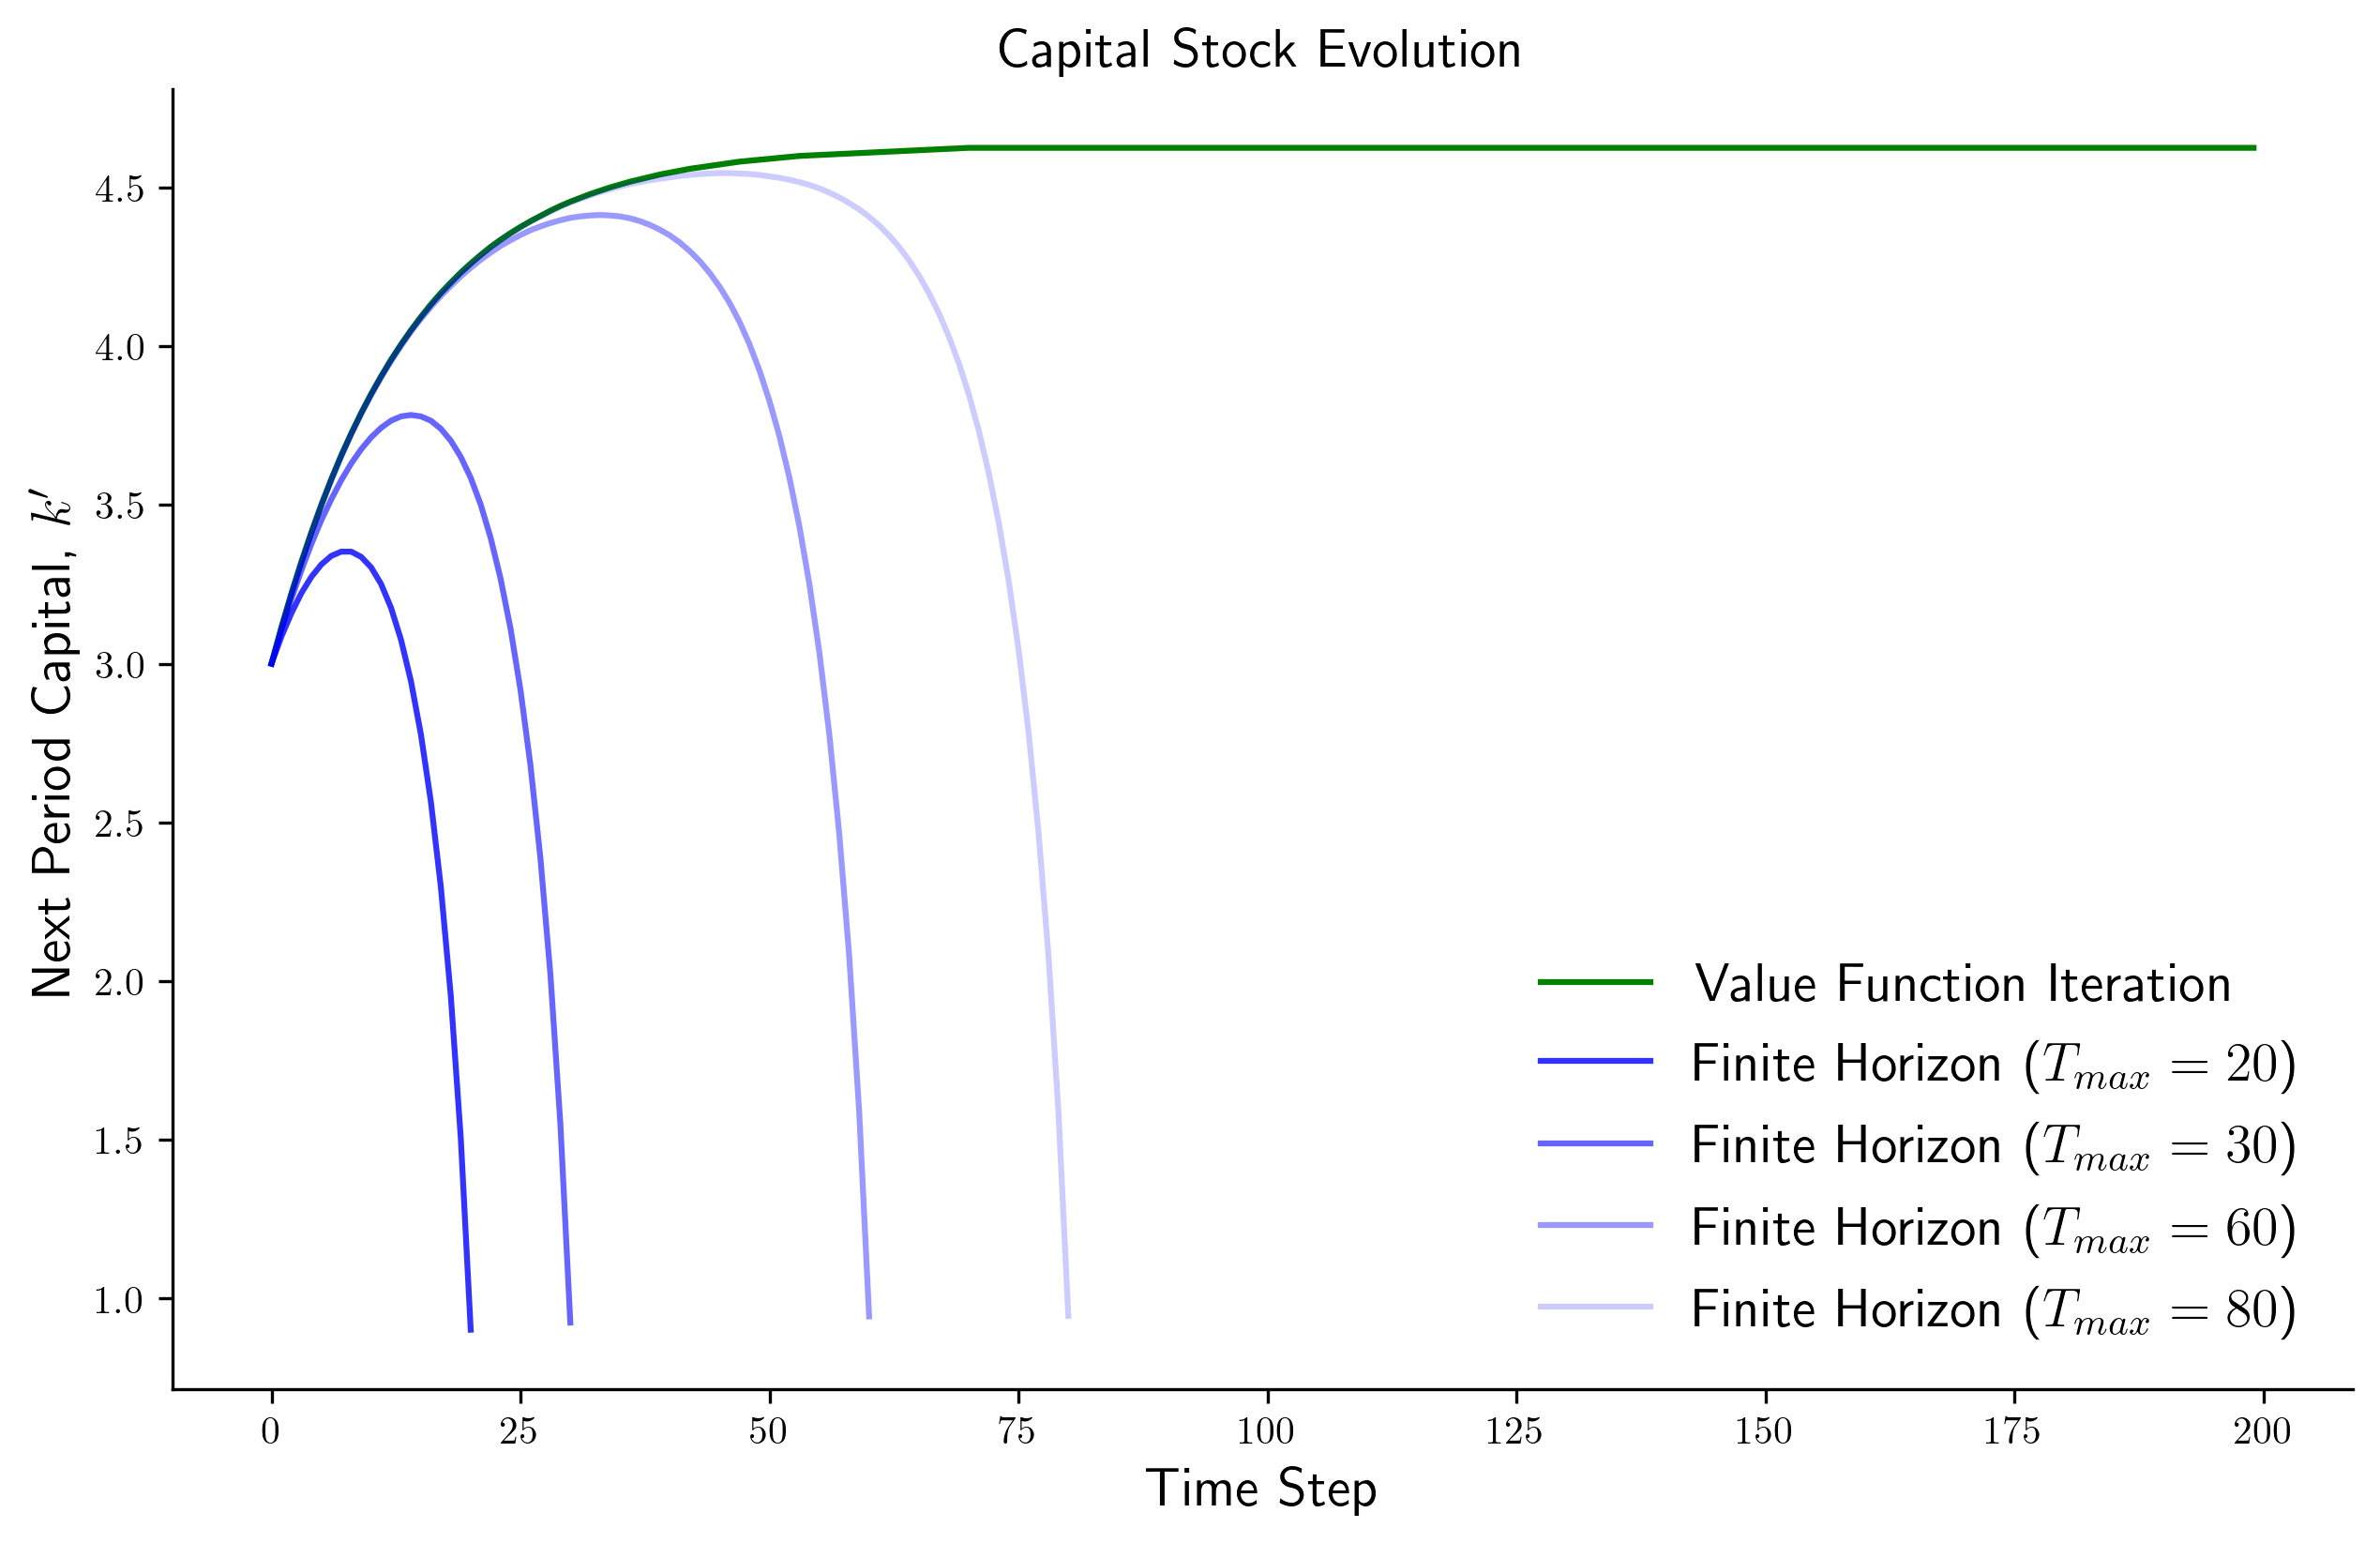

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(len(ks_vfi)), ks_vfi, color="green", label="Value Function Iteration")
ax.plot(
    np.arange(len(ks_finite_20)),
    ks_finite_20,
    color="blue",
    alpha=0.8,
    label="Finite Horizon ($T_{{max}} = 20$)",
)
ax.plot(
    np.arange(len(ks_finite_30)),
    ks_finite_30,
    color="blue",
    alpha=0.6,
    label="Finite Horizon ($T_{{max}} = 30$)",
)
ax.plot(
    np.arange(len(ks_finite_60)),
    ks_finite_60,
    color="blue",
    alpha=0.4,
    label="Finite Horizon ($T_{{max}} = 60$)",
)
ax.plot(
    np.arange(len(ks_finite_80)),
    ks_finite_80,
    color="blue",
    alpha=0.2,
    label="Finite Horizon ($T_{{max}} = 80$)",
)

ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Next Period Capital, $k^\prime$", size=14)
ax.set_xlabel("Time Step", size=14)
ax.set_title("Capital Stock Evolution", size=14)
ax.legend(frameon=False, fontsize=14)

plt.show()

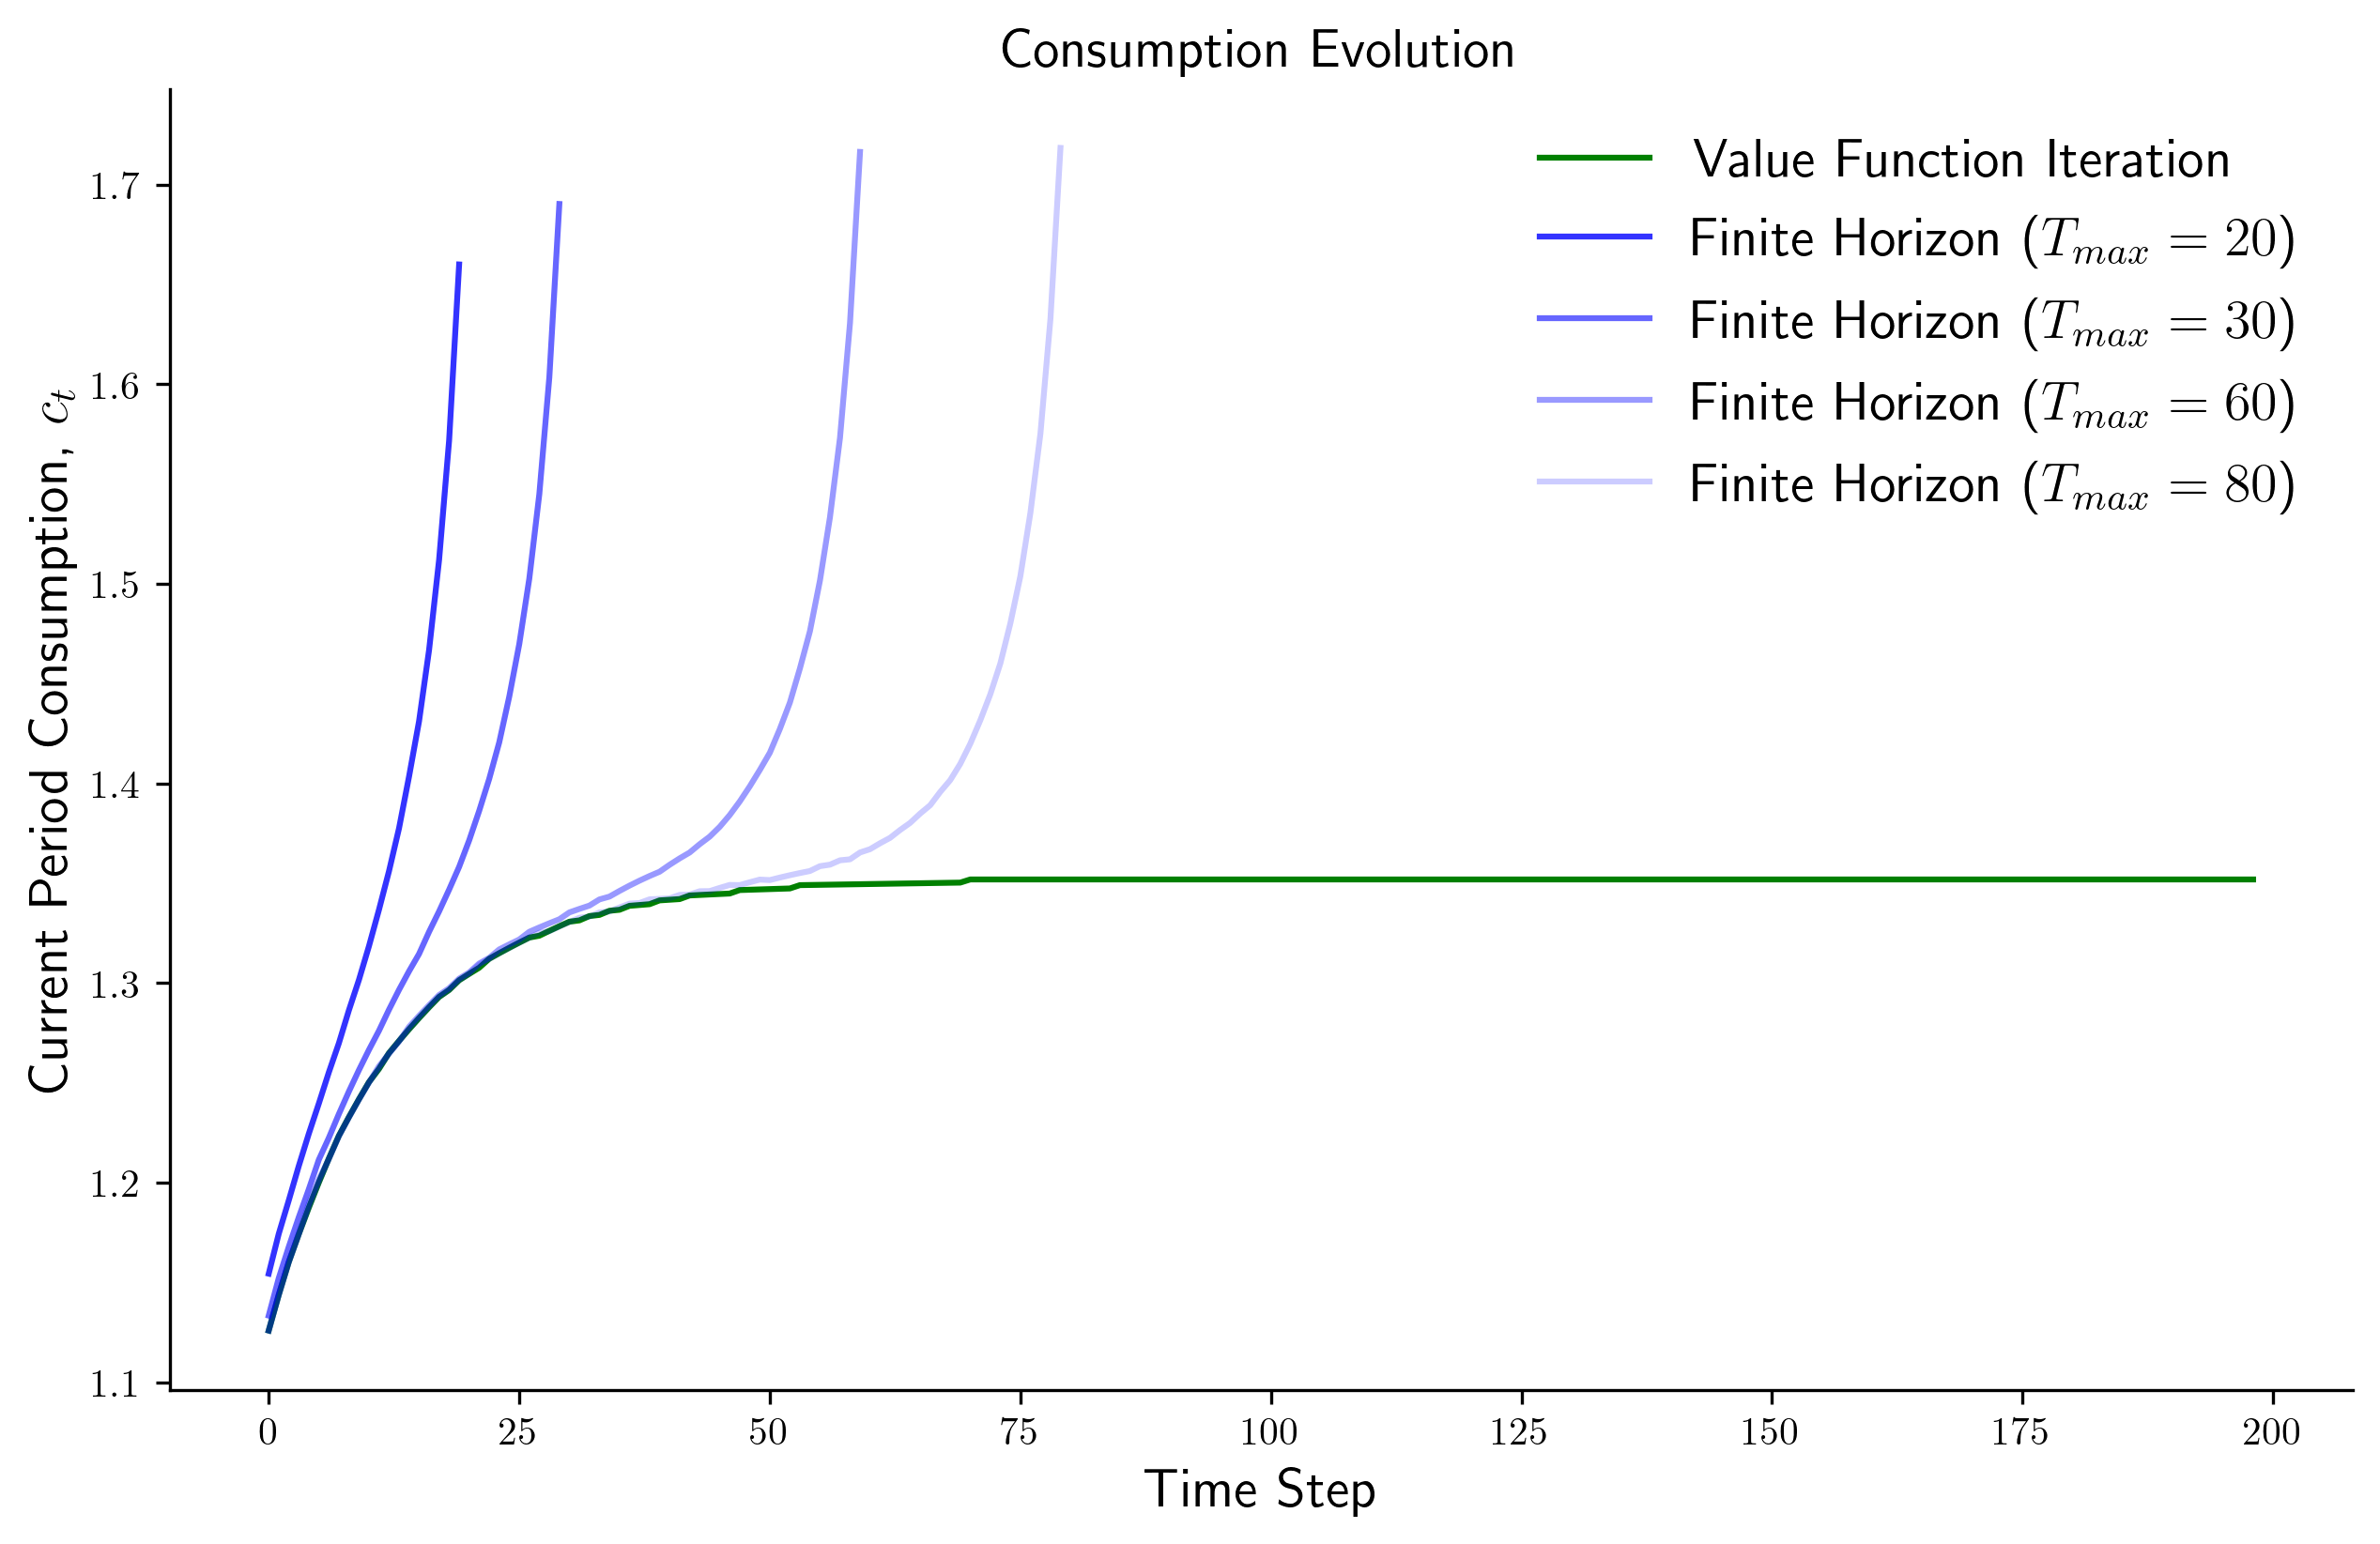

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(len(cs_vfi)), cs_vfi, color="green", label="Value Function Iteration")
ax.plot(
    np.arange(len(cs_finite_20)),
    cs_finite_20,
    color="blue",
    alpha=0.8,
    label="Finite Horizon ($T_{{max}} = 20$)",
)
ax.plot(
    np.arange(len(cs_finite_30)),
    cs_finite_30,
    color="blue",
    alpha=0.6,
    label="Finite Horizon ($T_{{max}} = 30$)",
)
ax.plot(
    np.arange(len(cs_finite_60)),
    cs_finite_60,
    color="blue",
    alpha=0.4,
    label="Finite Horizon ($T_{{max}} = 60$)",
)
ax.plot(
    np.arange(len(cs_finite_80)),
    cs_finite_80,
    color="blue",
    alpha=0.2,
    label="Finite Horizon ($T_{{max}} = 80$)",
)

ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Current Period Consumption, $c_t$", size=14)
ax.set_xlabel("Time Step", size=14)
ax.set_title("Consumption Evolution", size=14)
ax.legend(frameon=False, fontsize=14)

plt.show()